Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

Make sure notebook is opened in py365 environment

# Setup

In [1]:
%gui qt5 

In [23]:
# Imports in alphabetical order of module name

from IPython.display import display
from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt
import scipy.ndimage
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# Load images

## Segmentation channel

In [2]:
## Specify images to load

# folder2 = 'Z:\HCR\9.2_FISH\S1_dapi_546_488_647'
#folder = 'Z:\HCR\HCR_10.17\S1_DAPI_546_647_514_594'
folder = 'F:\HCR\HCR_10.17\S1_DAPI_546_647_514_594'

# base_filename2 = 'S1_dapi_546_488_647_s2z'
base_filename = 'S1_DAPI_546_647_514_594_z'

plane_nos = range(1, 30)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 29


In [18]:
# Background subtracted

img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))
h = img.height
w = img.width

im_array = np.zeros([n, h, w])
img_file = 'S1_Gad1_bg_sub2'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


In [4]:
# Create 4D array to store images
img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))
# img2 = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder2, base_filename2, str(plane_nos[0]).zfill(2)))

h = img.height
# h2 = img2.height                  
                  
w = img.width
# w2 = img2.width
                  
# c = np.array(img).shape[2]
im_array = np.zeros([n, h, w])
# im_array2 = np.zeros([n, h2, w2])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename, str(p).zfill(2)))
#     img2 = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder2, base_filename2, str(p).zfill(2)))
    try:
        im_array[i, :, :] = np.array(img)
#         im_array2[i, :, :] = np.array(img2)[:, :, 0]
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue


Size of image in pixels: 29 X 2866 X 11160
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


## Load other channels

In [4]:
#Background subtracted
print('Ndnf')
im_array_ndnf = np.zeros([n, h, w])
img_file = 'S1_Ndnf_bg_sub2'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_ndnf[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_ndnf = np.delete(im_array_ndnf, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

print('Vip')
im_array_vip = np.zeros([n, h, w])
img_file = 'S1_Vip_bg_sub2'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_vip[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_vip = np.delete(im_array_vip, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue
        
        
print('Sst')
im_array_sst = np.zeros([n, h, w])
img_file = 'S1_Sst_bg_sub2'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_sst[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_sst = np.delete(im_array_sst, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue    

Ndnf
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29
Vip
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29
Sst
Loading image 1
Loa

In [9]:
im_array_ndnf = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c3_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_ndnf[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_ndnf = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


In [10]:
im_array_vip = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c2_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_vip[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_vip = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


In [11]:
im_array_sst = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c5_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_sst[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_sst = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18
Loading image 19
Loading image 20
Loading image 21
Loading image 22
Loading image 23
Loading image 24
Loading image 25
Loading image 26
Loading image 27
Loading image 28
Loading image 29


# Annotation

## Data structure to store information about cells

In [5]:
class Cell:
    n_cells = 1
    cell_data = {}
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(1)
        print('Cell #{0} created'.format(Cell.n_cells))
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        Cell.cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}

In [6]:
# Load masks if they already exist
save_loc = 'Z:\HCR\HCR_10.17'
save_file= 'S1_data.pkl'
try:
    with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
        Cell.cell_data = pkl.load(f)
        indices = list(Cell.cell_data.keys())
        if not np.max(indices) == len(indices):
            print('Re-numbering cells to be consecutive')
            Cell.cell_data_temp = {}
            for i in range(len(indices)):
                Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
                Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
            Cell.cell_data = Cell.cell_data_temp 
            with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
            Cell.n_cells = i + 1
        else:
            Cell.n_cells = len(indices)
    print('{0} cells found'.format(Cell.n_cells))
except:
    print('No data found')

290 cells found


## Render image in napari GUI

In [8]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

viewer.add_image(im_array[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 0
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# # Add existing masks
# indices = list(Cell.cell_data.keys())
# mask_layer = viewer.layers['masks']
# for cell in indices:
#     plane = Cell.cell_data[cell]['z_planes'][0]
#     mask = Cell.cell_data[cell]['masks'][plane]
#     mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# # Keybinding functions

# @viewer.bind_key('n')
# def new_cell(viewer):
#     global cell1 
#     Cell.n_cells += 1
#     cell1 = Cell(Cell.n_cells)

# @viewer.bind_key('m')
# def add_mask(viewer):
#     seg_layer = viewer.layers[seg_channel]
#     z_plane = seg_layer.coordinates[0]
#     mask = viewer.layers['masks'].data[-1]
#     cell1.add_mask(z_plane, mask)
    
# @viewer.bind_key('k')
# def save_cell(viewer):
#     cell1.save_cell()
    
# @viewer.bind_key('Control-s')
# def save_all(viewer):
#     with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
#                 pkl.dump(Cell.cell_data, f)

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


<Shapes layer 'masks' at 0x2c0d240>

## Manual segmentation

In [21]:
Cell.n_cells

1

In [85]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 21 saved
Cell #22 created


In [87]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]


mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))

mask 2 added in z-plane 11 for cell 22


In [88]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

## Calculate intensity in other channels

In [182]:
with open('F:/HCR/HCR_10.17/S1_data_ndnf_sst_vip.pkl', 'rb') as f:
    signal = pkl.load(f)
    
avg_intensity_ndnf = signal['Ndnf']
avg_intensity_vip = signal['Vip']
avg_intensity_sst = signal['Sst']

In [7]:
try:
    with open('F:/HCR/HCR_10.17/S1_mask_vertices.pkl'.format(folder), 'rb') as f:
        mask_vertices = pkl.load(f)
        print('Data loaded')
        
except IOError:
    print('No saved data found, calculating mask pixels')
    xv = range(w)
    yv = range(h)
    coord_array = np.array(np.meshgrid(xv, yv))

    points = np.zeros([h*w, 2])
    p = 0
    for i in range(h):
        for j in range(w):
            points[p, 1] = coord_array[0, i, j]
            points[p, 0] = coord_array[1, i, j]
            p += 1

    no_cells = len(Cell.cell_data.keys())
    mask_vertices = {}
    for cell in range(no_cells):
        if np.mod(cell, 10) == 0:
            print('Cell {0}'.format(cell))
        cell_no = cell + 1
        mask_vertices[cell_no] = {}
        cell_dict = Cell.cell_data[cell_no]
        masks = cell_dict['masks']
        z_planes = cell_dict['z_planes']
        for plane in z_planes:

            vertices = masks[plane]
            path = mpltpath.Path(vertices)
            mask = path.contains_points(points)
            mask = np.reshape(mask, [h, w])
            mask_vertices[cell_no][plane] = np.where(mask)

    with open('F:/HCR/HCR_10.17/S1_mask_vertices.pkl'.format(folder), 'wb') as f:
        pkl.dump(mask_vertices, f)

Data loaded


In [9]:
no_cells = len(Cell.cell_data.keys())
avg_intensity_ndnf = np.zeros(no_cells)
avg_intensity_vip = np.zeros(no_cells)
avg_intensity_sst = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']

    intensity_ndnf = np.zeros(cell_dict['no_planes'])
    intensity_vip = np.zeros(cell_dict['no_planes'])
    intensity_sst = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        xy_coord = mask_vertices[cell_no][plane]
        x = xy_coord[0]
        y = xy_coord[1]
        intensity_ndnf[i] = np.mean(im_array_ndnf[plane, x, y])
        intensity_vip[i] = np.mean(im_array_vip[plane, x, y])
        intensity_sst[i] = np.mean(im_array_sst[plane, x, y])
        i += 1
    
    avg_intensity_ndnf[cell] = np.mean(intensity_ndnf)
    avg_intensity_vip[cell] = np.mean(intensity_vip)
    avg_intensity_sst[cell] = np.mean(intensity_sst)

    with open('F:/HCR/HCR_10.17/S1_data_ndnf_sst_vip.pkl', 'wb') as f:
        pkl.dump({'Ndnf': avg_intensity_ndnf, 'Sst': avg_intensity_sst, 'Vip':avg_intensity_vip}, f)

Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70
Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140
Cell 150
Cell 160
Cell 170
Cell 180
Cell 190
Cell 200
Cell 210
Cell 220
Cell 230
Cell 240
Cell 250
Cell 260
Cell 270
Cell 280


### Plotting

(array([ 47., 145.,  75.,   4.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   1.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.04502845, 0.06412788, 0.08322731, 0.10232674, 0.12142618,
        0.14052561, 0.15962504, 0.17872447, 0.1978239 , 0.21692333,
        0.23602276, 0.25512219, 0.27422162, 0.29332105, 0.31242049,
        0.33151992, 0.35061935, 0.36971878, 0.38881821, 0.40791764,
        0.42701707, 0.4461165 , 0.46521593, 0.48431536, 0.5034148 ,
        0.52251423, 0.54161366, 0.56071309, 0.57981252, 0.59891195,
        0.61801138, 0.63711081, 0.65621024, 0.67530967, 0.6944091 ,
        0.71350854, 0.73260797, 0.7517074 , 0.77080683, 0.78990626,
        0.80900569, 0.82810512, 0.84720455, 0.86630398, 0.88540341,
        0.90450285, 0.92360228, 0.94270171, 0.

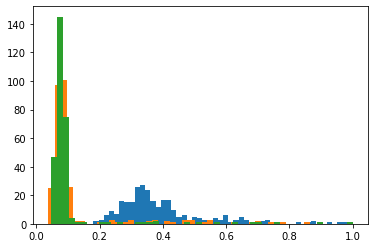

In [13]:
plt.hist(avg_intensity_ndnf/np.nanmax(avg_intensity_ndnf), 50)
plt.hist(avg_intensity_vip/np.nanmax(avg_intensity_vip), 50)
plt.hist(avg_intensity_sst/np.nanmax(avg_intensity_sst), 50)

In [181]:
plt.figure()
gene1_level = avg_intensity_vip
gene2_level = avg_intensity_sst

plt.scatter(gene1_level/np.max(gene1_level), gene2_level/np.max(gene2_level), 
            color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Vip')
plt.ylabel('Relative expression of Sst')

t1 = 0.4
t2 = 0.2

n_cells = Cell.n_cells
plt.plot(np.ones(2)*t1, np.array(range(0, 2)), '--', color = 'r')
plt.plot(np.array(range(0, 2)), np.ones(2)*t2, '--',  color = 'r')

q1 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0, 0, '{0} %'.format(np.round(q1/n_cells*100, decimals = 0)), fontsize = 12)

q2 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0, 1, '{0} %'.format(np.round(q2/n_cells*100, decimals = 0)), fontsize = 12)

q3 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0.8, 0, '{0} %'.format(np.round(q3/n_cells*100, decimals = 0)), fontsize = 12)

q4 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0.8, 1, '{0} %'.format(np.round(q4/n_cells*100, decimals = 0)), fontsize = 12)

Text(0.8, 1, '0.0 %')

In [23]:
plt.hist(avg_intensity_sst, 50)

(array([ 47., 145.,  75.,   4.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   1.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2691.7526056 ,  3833.49611737,  4975.23962914,  6116.98314092,
         7258.72665269,  8400.47016446,  9542.21367624, 10683.95718801,
        11825.70069978, 12967.44421156, 14109.18772333, 15250.9312351 ,
        16392.67474687, 17534.41825865, 18676.16177042, 19817.90528219,
        20959.64879397, 22101.39230574, 23243.13581751, 24384.87932929,
        25526.62284106, 26668.36635283, 27810.10986461, 28951.85337638,
        30093.59688815, 31235.34039993, 32377.0839117 , 33518.82742347,
        34660.57093525, 35802.31444702, 36944.05795879, 38085.80147057,
        39227.54498234, 40369.28849411, 41511.03200588, 42652.77551766,
        43

# View saved masks

In [22]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(Cell.cell_data, f)

In [60]:
Cell.n_cells

In [58]:
indices = list(Cell.cell_data.keys())
Cell.cell_data[indices[-1]]

{'cell_id': 138,
 'z_planes': [5, 6],
 'masks': {5: array([[ 1792.17393846, 10372.95009818],
         [ 1789.68810237, 10383.72205456],
         [ 1796.59320261, 10392.28437886],
         [ 1805.43173093, 10399.74188713],
         [ 1817.30850335, 10404.16115128],
         [ 1832.77592789, 10407.19939539],
         [ 1845.20510833, 10414.65690365],
         [ 1855.97706471, 10403.60874326],
         [ 1852.66261659, 10388.41752273],
         [ 1845.48131234, 10375.15973026],
         [ 1835.814172  , 10366.87360997],
         [ 1826.14703166, 10363.00675383],
         [ 1818.41331938, 10360.24471373],
         [ 1805.70793494, 10359.96850972],
         [ 1800.46005875, 10362.73054982],
         [ 1800.46005875, 10362.73054982]]),
  6: array([[ 1806.81275097, 10392.28437886],
         [ 1815.09887127, 10401.6753152 ],
         [ 1824.76601161, 10409.13282346],
         [ 1832.49972388, 10409.13282346],
         [ 1839.68102814, 10400.29429515],
         [ 1840.50964016, 10385.37927862],

In [52]:
cell1.masks

{0: array([[ 2503.06063306, 11088.27194031],
        [ 2500.96184674, 11094.14854202],
        [ 2499.28281768, 11105.06223091],
        [ 2499.70257495, 11113.03761894],
        [ 2512.29529289, 11115.55616253],
        [ 2521.52995272, 11117.65494886],
        [ 2531.60412708, 11117.23519159],
        [ 2545.45611683, 11113.45737621],
        [ 2555.11053392, 11108.42028903],
        [ 2559.30810657, 11098.34611467],
        [ 2562.66616469, 11088.69169757],
        [ 2558.88834931, 11078.61752322],
        [ 2548.81417495, 11073.58043604],
        [ 2542.93757324, 11071.06189245],
        [ 2529.50534076, 11071.06189245],
        [ 2521.11019546, 11075.2594651 ],
        [ 2507.67796298, 11078.61752322]]),
 1: array([[ 2497.60378862, 11095.82757108],
        [ 2495.5050023 , 11108.00053176],
        [ 2503.48039033, 11113.03761894],
        [ 2513.55456469, 11113.45737621],
        [ 2525.30776811, 11114.716648  ],
        [ 2537.06097153, 11113.03761894],
        [ 2545.03635956, 1

In [143]:
# Check number of masks per cell, and variance of mask centers
indices = list(Cell.cell_data.keys())
n_planes = np.zeros(len(indices)).astype(int)
var_masks = np.zeros([len(indices), 2])

if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    Cell.cell_data_temp = {}
    for i in range(len(indices)):
        Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
        Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
    Cell.cell_data = Cell.cell_data_temp 
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
        pkl.dump(Cell.cell_data, f)
        
for i in range(len(indices)):
    z_planes = Cell.cell_data[i + 1]['z_planes']
    n_planes[i] = len(z_planes)
    masks = Cell.cell_data[i + 1]['masks']
    centers = np.zeros([n_planes[i], 2])
    for j in range(n_planes[i]):
        centers[j, 0] = np.mean(masks[z_planes[j]][:, 0])
        centers[j, 1] = np.mean(masks[z_planes[j]][:, 1])
    var_masks[i, 0] = np.var(centers[:, 0])
    var_masks[i, 1] = np.var(centers[:, 1])
    
    

Re-numbering cells to be consecutive


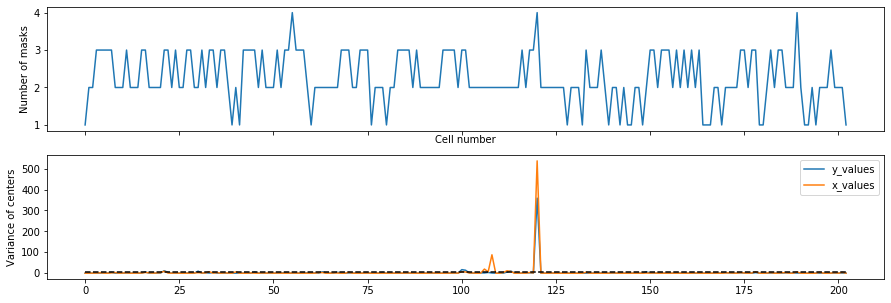

In [144]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 5])
ax[0].plot(n_planes)
ax[0].set_xlabel('Cell number')
ax[0].set_ylabel('Number of masks')
ax[1].plot(var_masks[:, 0], label = 'y_values')
ax[1].plot(var_masks[:, 1], label = 'x_values')
ax[1].set_ylabel('Variance of centers')
ax[1].plot(range(len(indices)), np.ones(len(indices))*8, '--', color = 'k')
ax[1].legend()

In [145]:
ind = np.nonzero(var_masks > 50)[0]

In [146]:
ind

array([108, 120, 120], dtype=int64)

In [147]:
cell_no = ind[2] + 1
masks = Cell.cell_data[cell_no]['masks']
masks

{14: array([[763.45916438, 911.99920008],
        [758.9540603 , 911.99920008],
        [756.79944531, 913.17444462],
        [755.23245258, 915.91668188],
        [755.23245258, 921.00940823],
        [755.82007485, 926.68975685],
        [759.54168257, 926.10213458],
        [762.47979393, 924.53514186],
        [765.61377937, 922.77227505],
        [767.37664619, 919.6382896 ],
        [767.96426846, 915.13318552],
        [767.57252028, 913.17444462]]),
 15: array([[799.6958711 , 865.38116656],
        [796.95363384, 866.16466292],
        [794.79901884, 868.51515201],
        [792.44852976, 870.08214473],
        [792.84027794, 874.19550063],
        [794.79901884, 876.9377379 ],
        [797.34538202, 878.30885653],
        [799.6958711 , 877.91710835],
        [801.65461201, 875.76249335],
        [803.61335291, 873.60787836],
        [805.18034563, 871.45326336],
        [805.18034563, 866.7522852 ],
        [804.78859745, 865.18529247],
        [804.00510109, 864.40179611]]),


In [120]:
Cell.cell_data.pop(cell_no)

{'cell_id': 30,
 'z_planes': [16, 17, 15],
 'masks': {16: array([[1080.85613872,  561.65899275],
         [1077.43598525,  561.45780725],
         [1074.21701728,  562.26254925],
         [1072.80871879,  564.87796072],
         [1076.22887226,  568.70048519],
         [1079.64902573,  572.32182416],
         [1081.86206621,  574.33367914],
         [1084.67866318,  574.13249364],
         [1086.48933267,  571.71826766],
         [1087.49526016,  568.29811419],
         [1086.69051816,  565.48151722],
         [1086.08696167,  564.27440423],
         [1085.48340517,  563.26847674]]),
  17: array([[1083.87392119,  563.06729124],
         [1079.24665473,  562.66492024],
         [1074.01583178,  562.86610574],
         [1070.79686381,  565.88388821],
         [1069.99212181,  568.70048519],
         [1072.0039768 ,  572.92538065],
         [1076.83242875,  574.93723563],
         [1080.45376772,  575.13842113],
         [1083.47155019,  574.53486464],
         [1085.68459067,  572.925380

## View saved masks in new napari window

In [326]:
# Open image in napari viewer - each channel as a separate layer 
viewer2 = napari.Viewer()

viewer2.add_image(im_array2[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
indices = list(Cell.cell_data.keys())
viewer2.add_shapes(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)
mask_layer = viewer2.layers['Shapes']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

In [303]:
mask_layer.add()

{1: {'cell_id': 1,
  'z_planes': [1],
  'masks': {1: array([[1203.88111044,  337.39930311],
          [1200.28185564,  338.59905471],
          [1197.08251804,  342.39826811],
          [1195.68280784,  345.19768851],
          [1199.28206264,  347.79715031],
          [1203.08127604,  349.59677772],
          [1206.88048944,  350.39661212],
          [1209.47995124,  348.99690192],
          [1211.47953724,  346.59739871],
          [1211.27957864,  342.99814391],
          [1208.48015824,  339.19893051],
          [1207.68032384,  338.19913751]])},
  'no_planes': 1,
  'c_vals': array([0.])},
 2: {'cell_id': 2,
  'z_planes': [1, 2],
  'masks': {1: array([[1211.33317027,  392.72244235],
          [1208.9794914 ,  393.21279212],
          [1208.48914163,  394.87998132],
          [1208.88142144,  398.41049963],
          [1209.96019093,  401.64680808],
          [1211.72545008,  403.41206723],
          [1214.17719891,  404.39276676],
          [1216.92315759,  405.47153624],
          

# View raw images of each cell

In [ ]:
centers = np.zeros([Cell.n_cells, 2])
med_planes = np.zeros(Cell.n_cells)

for cell in range(Cell.n_cells):
    
    cell_id = cell + 1
    planes = Cell.cell_data[cell_id]['z_planes']
    med_planes[cell] = int(np.median(planes))
    
    mask = Cell.cell_data[cell_id]['masks'][med_planes[cell]]
    centers[cell, :] = np.mean(mask, 0).astype(int)

In [1]:
gene = 'ndnf'

if gene == 'sst':
    im_array = im_array_sst
    cell_order = np.argsort(avg_intensity_sst)
elif gene == 'vip':
    im_array = im_array_vip
    cell_order = np.argsort(avg_intensity_vip)
elif gene == 'ndnf':
    im_array = im_array_ndnf
    cell_order = np.argsort(avg_intensity_ndnf)
    
n_rows = 10
n_cols = 29
fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))

size_um = 20 # In um
um_per_px = 0.19 # Size of a pixel in um
size_px = int(size_um/um_per_px/2)
mask_dil =  np.zeros([h, w]).astype(bool)

max_intensity = np.max(im_array)
min_intensity = np.min(im_array)

for cell in range(Cell.n_cells):
    
    row = int(cell/n_cols)
    col = np.mod(cell, n_cols)
    
    cell_id = cell_order[cell] + 1
    
    planes = Cell.cell_data[cell_id]['z_planes']
    med_plane = int(np.median(planes))
    
    mask = Cell.cell_data[cell_id]['masks'][med_plane]
    [x_center, y_center] = np.mean(mask, 0).astype(int)
    [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
    [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
    mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])
    
    small_im = np.reshape(im_array[med_plane, mask_dil], [np.min([x2 - x1, size_px*2]), np.min([y2 - y1, size_px*2])])
    ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)
    
    mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])
    
    ax[row, col].axis('off')
    if col == 0:
        ax[row, col].set_ylabel('{0}'.format(np.round(avg_intensity_ndnf[cell], 2)))
        ax[row, col].axis('on')

    


NameError: name 'im_array_ndnf' is not defined

# Find cortex surface and calculate distances

In [20]:
with open('F:/HCR/HCR_10.17/S1_depths.pkl', 'rb') as f:
    depths = pkl.load(f)

In [9]:
centers = np.zeros([Cell.n_cells, 2])
med_planes = np.zeros(Cell.n_cells)

for cell in range(Cell.n_cells):
    
    cell_id = cell + 1
    planes = Cell.cell_data[cell_id]['z_planes']
    med_planes[cell] = int(np.median(planes))
    
    mask = Cell.cell_data[cell_id]['masks'][med_planes[cell]]
    centers[cell, :] = np.mean(mask, 0).astype(int)

In [10]:
um_per_px = 0.19

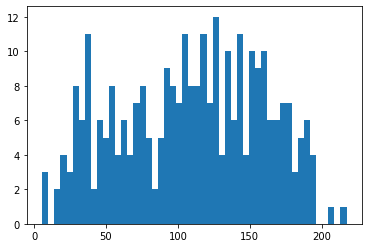

In [13]:
surface = viewer.layers['masks'].data[-1]
depths = np.zeros(Cell.n_cells)
for cell in range(Cell.n_cells):
    distances = np.linalg.norm(centers[cell, :] - surface, axis = 1)
    order = np.argsort(distances)
    [p1, p2] = order[0:2]
    d1 = surface[p1]
    d2 = surface[p2]
    depths[cell] = find_depth(d1, d2, centers[cell, :])
depths = depths*um_per_px
plt.figure()
plt.hist(depths, 50)
with open('F:/HCR/HCR_10.17/S1_depths.pkl', 'wb') as f:
    pkl.dump(depths, f)

In [12]:
def find_depth(d1, d2, cell_center): #d1 and d2 are two points on the surface closest to the cell center
    
    dx = d2[0] - d1[0]
    dy = d2[1] - d1[1]
    d1_cell_x = cell_center[0] - d1[0]
    d1_cell_y = cell_center[1] - d1[1]
    t = (dx * d1_cell_x + dy * d1_cell_y) / (dx * dx + dy * dy)
    px = d1[0] + t * dx # Projection of cell center onto line joining d1 and d2
    py = d1[1] + t * dy
    depth = np.linalg.norm([px - cell_center[0], py - cell_center[1]])
    return depth


In [150]:
max_depth = 80
all_cells = np.array(range(Cell.n_cells))
cell_ids = all_cells[depths < max_depth]

In [151]:
avg_intensity_shallow_ndnf = avg_intensity_ndnf[cell_ids]
avg_intensity_shallow_vip = avg_intensity_vip[cell_ids]
avg_intensity_shallow_sst = avg_intensity_sst[cell_ids]

In [152]:
plt.figure()
plt.hist(avg_intensity_shallow_sst, 50)

(array([ 8.,  5., 15., 12.,  8., 10.,  9.,  6.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3095.18426648,  3437.95202529,  3780.7197841 ,  4123.48754291,
         4466.25530173,  4809.02306054,  5151.79081935,  5494.55857816,
         5837.32633697,  6180.09409579,  6522.8618546 ,  6865.62961341,
         7208.39737222,  7551.16513104,  7893.93288985,  8236.70064866,
         8579.46840747,  8922.23616628,  9265.0039251 ,  9607.77168391,
         9950.53944272, 10293.30720153, 10636.07496034, 10978.84271916,
        11321.61047797, 11664.37823678, 12007.14599559, 12349.91375441,
        12692.68151322, 13035.44927203, 13378.21703084, 13720.98478965,
        14063.75254847, 14406.52030728, 14749.28806609, 15092.0558249 ,
        15434.82358371, 15777.59134253, 16120.35910134, 16463.126860

In [153]:
plt.figure()
gene1_level = avg_intensity_shallow_ndnf
gene2_level = avg_intensity_shallow_vip

plt.scatter(gene1_level/np.max(gene1_level), gene2_level/np.max(gene2_level), 
            color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Ndnf')
plt.ylabel('Relative expression of Vip')

t1 = 0.4
t2 = 0.2

n_cells = cell_ids.shape[0]
plt.plot(np.ones(2)*t1, np.array(range(0, 2)), '--', color = 'r')
plt.plot(np.array(range(0, 2)), np.ones(2)*t2, '--',  color = 'r')

q1 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0, 0, '{0} %'.format(np.round(q1/n_cells*100, decimals = 0)), fontsize = 12)

q2 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0, 1, '{0} %'.format(np.round(q2/n_cells*100, decimals = 0)), fontsize = 12)

q3 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0.8, 0, '{0} %'.format(np.round(q3/n_cells*100, decimals = 0)), fontsize = 12)

q4 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0.8, 1, '{0} %'.format(np.round(q4/n_cells*100, decimals = 0)), fontsize = 12)

Text(0.8, 1, '0.0 %')

In [135]:
depths.shape

(290,)

In [136]:
avg_intensity_ndnf.shape

(290,)

In [156]:
plt.figure()
plt.scatter(depths, avg_intensity_ndnf, color = 'k', alpha = 0.5)
plt.xlabel('Depth')
plt.ylabel('Ndnf level')

Text(0, 0.5, 'Ndnf level')

In [154]:
plt.figure()
plt.scatter(depths, avg_intensity_sst, color = 'k', alpha = 0.5)
plt.xlabel('Depth')
plt.ylabel('Sst level')

Text(0, 0.5, 'Sst level')

In [155]:
plt.figure()
plt.scatter(depths, avg_intensity_vip, color = 'k', alpha = 0.5)
plt.xlabel('Depth')
plt.ylabel('Vip level')


Text(0, 0.5, 'Vip level')

Text(0.5, 1.0, 'Max intensity = 55685')

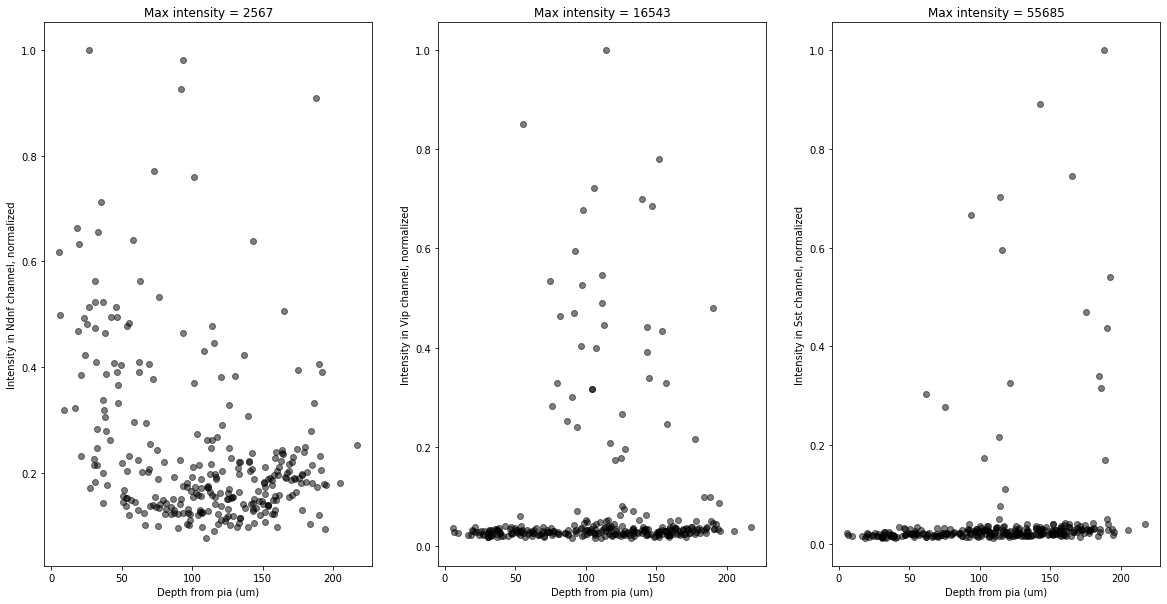

In [21]:
# Plot intensity vs depth for all channels
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

ax[0].scatter(depths, avg_intensity_ndnf/np.max(avg_intensity_ndnf), color = 'k', alpha = 0.5)
ax[0].set_xlabel('Depth from pia (um)')
ax[0].set_ylabel('Intensity in Ndnf channel, normalized')
ax[0].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_ndnf))))

ax[1].scatter(depths, avg_intensity_vip/np.max(avg_intensity_vip), color = 'k', alpha = 0.5)
ax[1].set_xlabel('Depth from pia (um)')
ax[1].set_ylabel('Intensity in Vip channel, normalized')
ax[1].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_vip))))

ax[2].scatter(depths, avg_intensity_sst/np.max(avg_intensity_sst), color = 'k', alpha = 0.5)
ax[2].set_xlabel('Depth from pia (um)')
ax[2].set_ylabel('Intensity in Sst channel, normalized')
ax[2].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_sst))))

# Local background correction

## Define background pixels

In [8]:
# All pixels not contained in any cell mask
bg_all = np.ones([n, h, w])
n_vert_all = {}
centers = {}

no_cells = len(Cell.cell_data.keys())
for cell in range(no_cells):
        
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']
    n_vert_all[cell] = {}
    centers[cell] = {}
    
    for plane in z_planes:
        
        xy_coord = mask_vertices[cell_no][plane]
        x = xy_coord[0]
        y = xy_coord[1]
        z = plane
        centers[cell][plane] = np.array([np.mean(x), np.mean(y)]).astype(int)
        
        
        bg_all[z, x, y] = np.zeros([1, len(x)])
        
        n_vert_all[cell][plane] = len(x) 
        

Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70
Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140
Cell 150
Cell 160
Cell 170
Cell 180
Cell 190
Cell 200
Cell 210
Cell 220
Cell 230
Cell 240
Cell 250
Cell 260
Cell 270
Cell 280


## Find local background of each cell

In [12]:
%matplotlib qt

In [20]:
fig, ax = plt.subplots(nrows = 3, ncols = 20)
um_per_px = 0.19
no_cells = len(Cell.cell_data.keys())
avg_bg_ndnf = np.zeros(no_cells)
avg_bg_vip = np.zeros(no_cells)
avg_bg_sst = np.zeros(no_cells)

local_region = 50 # in um
local_px = int(local_region/um_per_px/2)

min_dist = 10 # in um
min_dist_px = min_dist/um_per_px

for cell in range(20):
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']

    bg_ndnf = np.zeros(len(z_planes))
    bg_vip = np.zeros(len(z_planes))
    bg_sst = np.zeros(len(z_planes))

    p = 0
    for plane in z_planes:

        center = centers[cell][plane]
        n_verts = n_vert_all[cell][plane]

        x1 = np.max([0, center[0] - local_px])
        x2 = np.min([h, center[0] + local_px])
        y1 = np.max([0, center[1] - local_px])
        y2 = np.min([w, center[1] + local_px])

        center_local = [local_px, local_px]

        local_bg = bg_all[plane, x1:x2, y1:y2].astype(bool)
        local_im_ndnf = im_array_ndnf[plane, x1:x2, y1:y2]
        local_im_sst = im_array_sst[plane, x1:x2, y1:y2]
        local_im_vip = im_array_vip[plane, x1:x2, y1:y2]
        local_im = im_array[plane, x1:x2, y1:y2]

        ax[0, cell].imshow(local_im, vmin = np.min(local_im), vmax = np.max(local_im)/2)
        ax[1, cell].imshow(local_bg)
        
        verts = np.array(np.where(local_bg))
        dist_from_center = np.linalg.norm(verts - np.reshape(center_local, [2, 1]), axis = 0)
        verts = verts[:, dist_from_center > min_dist_px]
        dist_from_center = dist_from_center[dist_from_center > min_dist_px]
        
        order = np.argsort(dist_from_center)
        # Take 4x the number of pixels in the mask of the cell, for local background - it will still be local but you'll
        # get a better estimate of background by averaging over more pixels.
        n_verts = np.min([4*n_verts, len(order)])
        
        x_bg = verts[0][order[0:n_verts]]
        y_bg = verts[1][order[0:n_verts]]

        local_bg = np.zeros(local_bg.shape).astype(bool)
        local_bg[x_bg, y_bg] = np.ones(n_verts)

        ax[2, cell].imshow(local_bg)

        bg_ndnf[p] = np.mean(local_im_ndnf[local_bg])
        bg_vip[p] = np.mean(local_im_vip[local_bg])
        bg_sst[p] = np.mean(local_im_sst[local_bg])

        p += 1



    avg_bg_ndnf[cell] = np.mean(bg_ndnf)
    avg_bg_vip[cell] = np.mean(bg_vip)
    avg_bg_sst[cell] = np.mean(bg_sst)
    
#with open('F:/HCR/HCR_10.17/S1_background_ndnf_sst_vip.pkl', 'wb') as f:
 #   pkl.dump({'Ndnf': avg_bg_ndnf, 'Sst': avg_bg_sst, 'Vip':avg_bg_vip}, f)

# Use background to estimate significance of signal

Idea: use sub-sampling of n_vert pixels from local_bg, to create a distribution of values of avg_bg_ndnf. Then choose the 95th percentile of this distribution as the threshold above which avg_intensity_ndnf is significant.

## General bootstrap - sanity check

In [69]:
pop = np.random.normal(loc = 0, scale = 1, size = 50000) #population
ci_real = np.percentile(pop, (5, 95))

n_samples = 100
sample_size = np.linspace(10, 2000, 50).astype(int)
ci_sample = 1.645/np.sqrt(sample_size)
n = len(sample_size)

ci = np.zeros([2, n])

for i in range(n):
    samples = np.random.choice(pop, size = (sample_size[i], n_samples), replace=True)
    means = np.mean(samples, 0)
    ci[:, i] = np.percentile(means, (5, 95))

In [70]:
plt.figure()
plt.plot(sample_size, np.zeros(n), label = 'True mean')
plt.plot(sample_size, ci[0, :], label = '5% confidence interval')
plt.plot(sample_size, ci[1, :], label = '95% confidence interval')
plt.plot(sample_size, ci_sample, label = 'True 95% confidence interval')
plt.legend()
plt.xlabel('Number of bootstrap samples')

Text(0.5, 0, 'Number of bootstrap samples')

In [71]:
plt.close('all')

## Bootstrap background to get confidence interval

### Calculate 95% confidence interval for each cell by bootstrapping background

In [197]:
n_sample = 1000 # Number of samples to calculate bootstrap confidence interval
p_value = 0.05 # Threshold for calling signal significantly different from background

no_cells = len(Cell.cell_data.keys())

ci_ndnf = np.zeros(no_cells)
ci_vip = np.zeros(no_cells)
ci_sst = np.zeros(no_cells)

pv_ndnf = np.zeros(no_cells)
pv_vip = np.zeros(no_cells)
pv_sst = np.zeros(no_cells)

um_per_px = 0.19

local_region = 50 # in um
local_px = int(local_region/um_per_px/2)

min_dist = 10 # in um
min_dist_px = min_dist/um_per_px

for cell in range(no_cells):

    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
        
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']
    
    bs_means = np.zeros([n_sample, 3, len(z_planes)])
    p = 0
    
    for plane in z_planes:

        center = centers[cell][plane]
        n_verts = n_vert_all[cell][plane]

        x1 = np.max([0, center[0] - local_px])
        x2 = np.min([h, center[0] + local_px])
        y1 = np.max([0, center[1] - local_px])
        y2 = np.min([w, center[1] + local_px])

        center_local = [local_px, local_px]

        local_bg = bg_all[plane, x1:x2, y1:y2].astype(bool)

        verts = np.array(np.where(local_bg))
        dist_from_center = np.linalg.norm(verts - np.reshape(center_local, [2, 1]), 
                                          axis = 0)
        verts = verts[:, dist_from_center > min_dist_px]
        dist_from_center = dist_from_center[dist_from_center > min_dist_px]

        order = np.argsort(dist_from_center)
        # Take 4x the number of pixels in the mask of the cell, for local background - it will still be local but you'll
        # get a better estimate of background by averaging over more pixels.
        n_verts_bg = np.min([4*n_verts, len(order)])

        verts = verts[:, order[0:n_verts_bg]]
        samples = np.random.choice(np.linspace(0, n_verts_bg - 1, n_verts_bg).astype(int), 
                                   (n_verts, n_sample), replace = True)
        x_bs = verts[0][samples]
        y_bs = verts[1][samples]

        local_im_ndnf = im_array_ndnf[plane, x1:x2, y1:y2]
        local_im_sst = im_array_sst[plane, x1:x2, y1:y2]
        local_im_vip = im_array_vip[plane, x1:x2, y1:y2]


        local_bg_bs = np.zeros([x2 - x1, y2 - y1]).astype(bool)
        for s in range(n_sample):
            local_bg_bs[x_bs[:, s], y_bs[:, s]] = np.ones(n_verts)
            bs_means[s, 0, p] = np.mean(local_im_ndnf[local_bg_bs])
            bs_means[s, 1, p] = np.mean(local_im_vip[local_bg_bs])
            bs_means[s, 2, p] = np.mean(local_im_sst[local_bg_bs])

        p += 1

        pv_ndnf[cell] = np.sum(bs_means[:, 0, :] > avg_intensity_ndnf[cell])/n_sample/len(z_planes)
        pv_vip[cell] = np.sum(bs_means[:, 1, :] > avg_intensity_vip[cell])/n_sample/len(z_planes)
        pv_sst[cell] = np.sum(bs_means[:, 2, :] > avg_intensity_sst[cell])/n_sample/len(z_planes)
        
        ci_ndnf[cell] = np.mean(np.percentile(bs_means[:, 0, :], (1 - p_value)*100, axis = 0))
        ci_vip[cell] = np.mean(np.percentile(bs_means[:, 1, :], (1 - p_value)*100, axis = 0))
        ci_sst[cell] = np.mean(np.percentile(bs_means[:, 2, :], (1 - p_value)*100, axis = 0))

with open('F:/HCR/HCR_10.17/S1_confidence_intervals_ndnf_sst_vip.pkl', 'wb') as f:
    pkl.dump({'Ndnf': ci_ndnf, 'Sst': ci_sst, 'Vip':ci_vip}, f)
    
with open('F:/HCR/HCR_10.17/S1_p_values_ndnf_sst_vip.pkl', 'wb') as f:
    pkl.dump({'Ndnf': pv_ndnf, 'Sst': pv_sst, 'Vip':pv_vip}, f)

Cell 0


NameError: name 'bg_all' is not defined

### Check bootstrapped local background pixels

In [160]:
fig, ax = plt.subplots(nrows = 10, ncols = 10)
for s in range(n_sample):
    row = int(s/10)
    col = np.mod(s, 10)
    ax[row, col].imshow(local_bg_bs[s, :, :], vmin = 0, vmax = 1)

## Estimate p-value of signal of each cell by bootstrapping background

In [196]:
n_sample = 1000 # Number of samples to calculate bootstrap confidence interval

no_cells = len(Cell.cell_data.keys())
pv_ndnf = np.zeros(no_cells)
pv_vip = np.zeros(no_cells)
pv_sst = np.zeros(no_cells)

um_per_px = 0.19

local_region = 50 # in um
local_px = int(local_region/um_per_px/2)

min_dist = 10 # in um
min_dist_px = min_dist/um_per_px

%timeit
for cell in range(no_cells):

    if np.mod(cell, 5) == 0:
        print('Cell {0}'.format(cell))
        
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']
    for plane in z_planes:

        center = centers[cell][plane]
        n_verts = n_vert_all[cell][plane]

        x1 = np.max([0, center[0] - local_px])
        x2 = np.min([h, center[0] + local_px])
        y1 = np.max([0, center[1] - local_px])
        y2 = np.min([w, center[1] + local_px])

        center_local = [local_px, local_px]

        local_bg = bg_all[plane, x1:x2, y1:y2].astype(bool)

        verts = np.array(np.where(local_bg))
        dist_from_center = np.linalg.norm(verts - np.reshape(center_local, [2, 1]), axis = 0)
        verts = verts[:, dist_from_center > min_dist_px]
        dist_from_center = dist_from_center[dist_from_center > min_dist_px]

        order = np.argsort(dist_from_center)
        # Take 4x the number of pixels in the mask of the cell, for local background - it will still be local but you'll
        # get a better estimate of background by averaging over more pixels.
        n_verts_bg = np.min([4*n_verts, len(order)])

        verts = verts[:, order[0:n_verts_bg]]
        samples = np.random.choice(np.linspace(0, n_verts_bg - 1, n_verts_bg).astype(int), (n_verts, n_sample), replace = True)
        x_bs = verts[0][samples]
        y_bs = verts[1][samples]

        local_im_ndnf = im_array_ndnf[plane, x1:x2, y1:y2]
        local_im_sst = im_array_sst[plane, x1:x2, y1:y2]
        local_im_vip = im_array_vip[plane, x1:x2, y1:y2]

        bs_means = np.zeros([n_sample, 3])

        local_bg_bs = np.zeros([x2 - x1, y2 - y1]).astype(bool)
        for s in range(n_sample):
            local_bg_bs[x_bs[:, s], y_bs[:, s]] = np.ones(n_verts)
            bs_means[s, 0] = np.mean(local_im_ndnf[local_bg_bs])
            bs_means[s, 1] = np.mean(local_im_vip[local_bg_bs])
            bs_means[s, 2] = np.mean(local_im_sst[local_bg_bs])


        pv_ndnf[cell] = np.sum(bs_means[:, 0] > avg_intensity_ndnf[cell])/n_sample
        pv_vip[cell] = np.sum(bs_means[:, 1] > avg_intensity_vip[cell])/n_sample
        pv_sst[cell] = np.sum(bs_means[:, 2] > avg_intensity_sst[cell])/n_sample

with open('F:/HCR/HCR_10.17/S1_p_values_ndnf_sst_vip.pkl', 'wb') as f:
    pkl.dump({'Ndnf': pv_ndnf, 'Sst': pv_sst, 'Vip':pv_vip}, f)

Cell 0
Cell 5
Cell 10
Cell 15
Cell 20
Cell 25
Cell 30
Cell 35
Cell 40
Cell 45
Cell 50
Cell 55
Cell 60
Cell 65
Cell 70
Cell 75
Cell 80
Cell 85
Cell 90
Cell 95
Cell 100
Cell 105
Cell 110
Cell 115
Cell 120
Cell 125
Cell 130
Cell 135
Cell 140
Cell 145
Cell 150
Cell 155
Cell 160
Cell 165
Cell 170
Cell 175
Cell 180
Cell 185
Cell 190
Cell 195
Cell 200
Cell 205
Cell 210
Cell 215
Cell 220
Cell 225
Cell 230
Cell 235
Cell 240
Cell 245
Cell 250
Cell 255
Cell 260
Cell 265
Cell 270
Cell 275
Cell 280
Cell 285


In [198]:
cell_order = np.argsort(avg_intensity_ndnf - avg_bg_ndnf - ci_ndnf)

plt.figure()
plt.plot(pv_ndnf[cell_order], marker = 'o')

In [199]:
pv_ndnf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [195]:
plt.figure()
plt.hist(pv_vip, 20)

(array([219.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  71.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)